In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from PIL import Image
import glob
import os

# Dataset

## Visualization utils

In [2]:
def plot_samples(dataset, split, seed):
    np.random.seed(seed)
    print(f"Plot Samples (seed = {seed}, {split} split)")

    plt.figure(figsize=(10, 5))
    found_samples = {i: False for i in range(8)}
    
    while not all(found_samples.values()):
        idx = np.random.randint(0, len(dataset))
        image , label = dataset[idx]
        if found_samples[label]:
            continue
        # Plot the image
        plt.subplot(2, 4, label + 1)
        plt.imshow(image.squeeze().permute(1, 2, 0))
        plt.title(f'Label: {label}')
        plt.axis('off')
        found_samples[label] = True
    plt.tight_layout()
    plt.show()
    
def plot_label_distribution_histogram(dataset, split):
    labels = [label for _, label in dataset]

    counts = [labels.count(i) for i in range(8)]

    fig, ax = plt.subplots()
    ax.bar(range(8), counts)

    for i in range(8):
        ax.text(i, counts[i], f"{100*(counts[i]/sum(counts)):.1f} %", ha="center", va="bottom")

    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    ax.set_xticks(range(8))
    ax.set_xticklabels(range(8), ha="center")
    ax.set_title(f"Histogram of labels distribution for {split} split")
    plt.tight_layout()
    plt.show()

## Load and Prepare datasets

In [3]:
TRAIN_DATA_PATH = "dataset/TRAIN"
TUNE_DATA_PATH = "dataset/TUNE"
TRAIN_SPLIT_OF_ALL = 0.8

In [4]:
scale = torchvision.transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))
transforms_augment = transforms.Compose([
    transforms.RandomRotation(degrees=20), 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    scale,
])
transforms_norm = transforms.Compose([
    transforms.ToTensor(),
    scale,
])

train_valid_aug_dataset = ImageFolder(
    root=TRAIN_DATA_PATH,
    transform=transforms_augment,
)
train_valid_raw_dataset = ImageFolder(
    root=TRAIN_DATA_PATH,
    transform=transforms_norm,
)
train_valid_dataset = torch.utils.data.ConcatDataset([train_valid_raw_dataset, train_valid_aug_dataset])
tune_dataset = ImageFolder(
    root=TUNE_DATA_PATH,
    transform=transforms_norm,
)

## Explore datasets

Plot Samples (seed = 21, train+valid split)


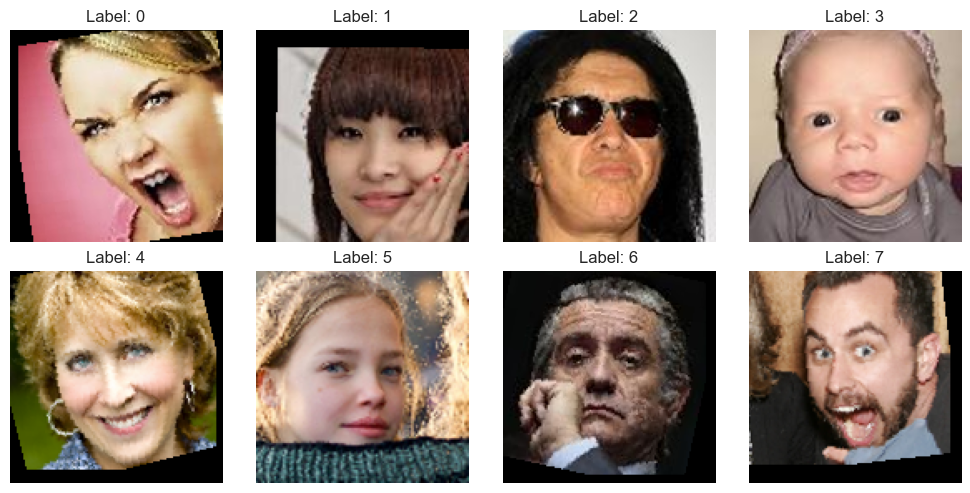

In [5]:
plot_samples(
    dataset=train_valid_dataset, 
    split="train+valid", 
    seed=21,
)

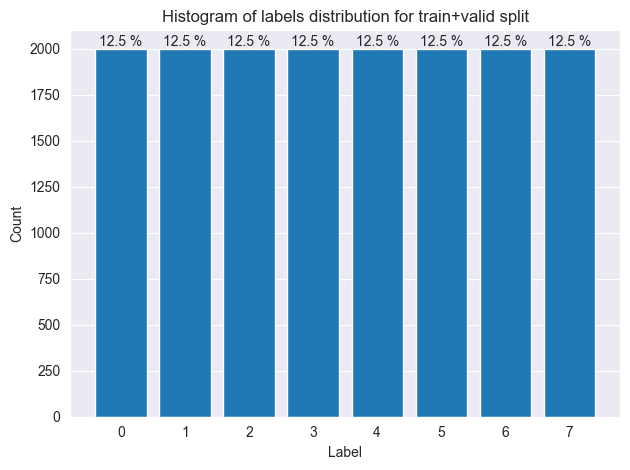

In [6]:
plot_label_distribution_histogram(
    dataset=train_valid_dataset, 
    split="train+valid",
)

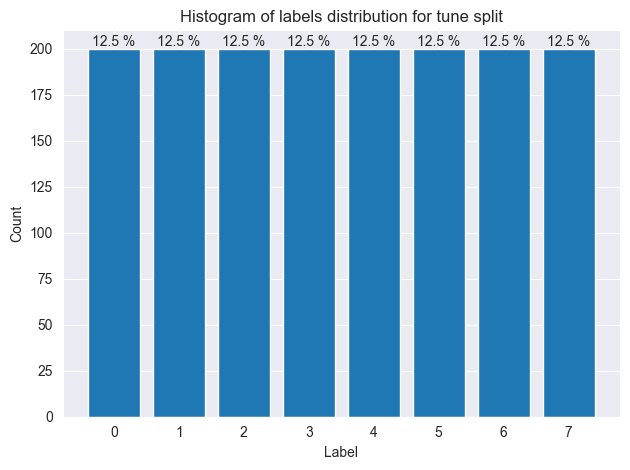

In [7]:
plot_label_distribution_histogram(
    dataset=tune_dataset, 
    split="tune",
)

## Split train-validation

In [8]:
labels = [sample[1] for sample in train_valid_dataset]

train_dataset, valid_dataset = train_test_split(
    train_valid_dataset,
    train_size=TRAIN_SPLIT_OF_ALL,
    stratify=labels,
    random_state=42
)

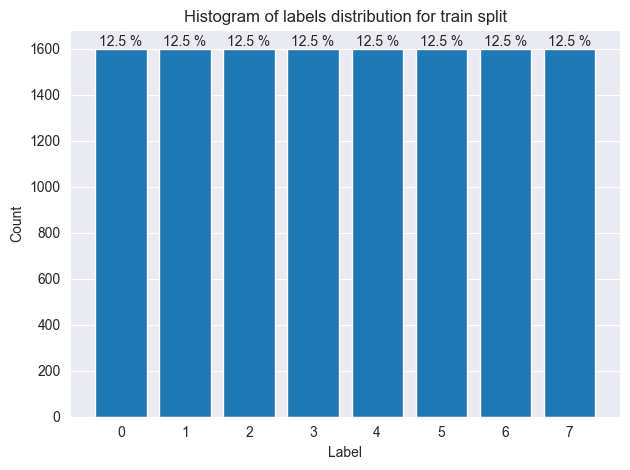

In [9]:
plot_label_distribution_histogram(
    dataset=train_dataset, 
    split="train",
)

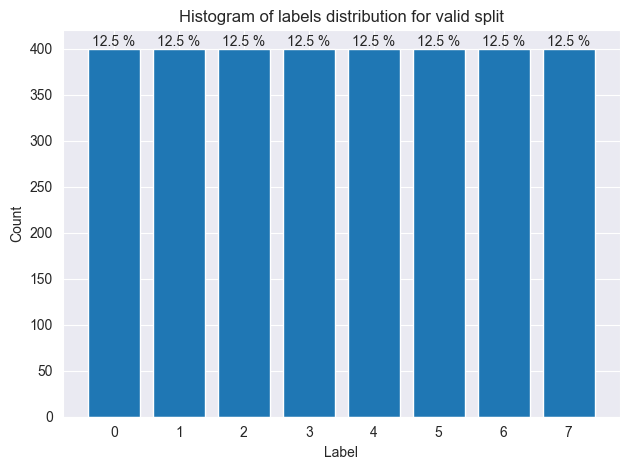

In [10]:
plot_label_distribution_histogram(
    dataset=valid_dataset, 
    split="valid",
)

# Models

## Utils

### Train-Eval helpers

In [11]:
@torch.no_grad()
def model_eval(model, loader, loss_function=nn.CrossEntropyLoss(), device="auto"):
    """Returns test_loss, test_accuracy"""
    test_loss = 0.0
    test_correct = 0
    sample_count = 0
    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = loss_function(outputs, labels)

        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels).item()
        sample_count += np.shape(inputs)[0]

        itr.set_description("(Eval)")
        itr.set_postfix(loss=round(loss.item(), 5), accuracy=round(test_correct/sample_count, 2))

    test_loss = test_loss / len(loader)
    test_acc = test_correct / sample_count

    return test_loss, test_acc


def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        test_set=None,
        device="auto",
):
    """
    If test_set is not None, it would evaluate model for each epoch,
    train_set would be in  N*(img, label) format.
    """
    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    needs_test_evaluation = test_set is not None

    train_loss_list = []
    train_acc_list = []

    test_loss_list = None if test_set is None else []
    test_acc_list = None if test_set is None else []

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    if needs_test_evaluation:
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    model.train()

    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        samples_count = 0
        itr = tqdm(train_loader, total=len(train_loader), leave=False)

        for inputs, labels in itr:
            samples_count += np.shape(inputs)[0]
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()


            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(loss=round(loss.item(), 5), accuracy=round(train_correct/samples_count, 3))

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / len(train_set)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        if needs_test_evaluation:
            test_loss, test_acc = model_eval(
                model=model,
                device=device,
                loader=test_loader,
            )

            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)

    history = {
        "train loss": train_loss_list,
        "train acc": train_acc_list,
    }
    if needs_test_evaluation:
        history.update({
            "test loss": test_loss_list,
            "test acc": test_acc_list,
        })

    return history

### Costume conv block

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_chan, out_chan, kernel=(3,3), stride=(1,1), padding="same"):
        super(ConvBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_chan, out_channels=out_chan, kernel_size=kernel, padding=padding, stride=stride),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Dropout(p=0.2),
        )
    def forward(self, x):
        return self.block(x)
        

## AlexNet model

In [13]:
class AlexNet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(AlexNet, self).__init__()
        
        self.network = nn.Sequential(
            ConvBlock(in_chan=in_channel, out_chan=16, kernel=(9,9)),
            ConvBlock(in_chan=16, out_chan=32, kernel=(7,7)),
            ConvBlock(in_chan=32, out_chan=64, kernel=(5,5)),
            ConvBlock(in_chan=64, out_chan=128, kernel=(3, 3)),
            ConvBlock(in_chan=128, out_chan=128, kernel=(3,3)),
            
            nn.Flatten(),
            
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=1024, out_features=num_classes),
        )
        
        self.av_net = nn.Linear(num_classes, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        return self.softmax(self.network(x))
        # for module in self.network:
        #     print(x.shape)
        #     print(module.__class__.__name__)
        #     x = module(x)
        #     print(x.shape)
        #     print("*---------------*")
        # print(">> final shape:", x.shape)
        # return self.softmax(x)
        

## VGG model

## MobileNet model

# Train and Tune models

## AlexNet

In [14]:
alexnet_model = AlexNet(in_channel=3, num_classes=8)

# train_loader = DataLoader(train_dataset, batch_size=400, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=400, shuffle=False)
# Tune_loader = DataLoader(tune_dataset, batch_size=400, shuffle=True)

In [ ]:
train_model(
    model=alexnet_model,
    batch_size=400,
    loss_function=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(alexnet_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8),
    epochs=24,
    train_set=train_dataset,
    test_set=valid_dataset,
)

(Training) Epoch [2/24]:  12%|█▎        | 4/32 [00:25<02:54,  6.24s/it, accuracy=0.146, loss=2.07] 

data